### import

In [1]:
import pickle
import nltk
import utils
import mlflow
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from mlflow.data.pandas_dataset import PandasDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
#from gensim.summarization import summarize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import shap
from sklearn.cluster import AgglomerativeClustering

prt = nltk.stem.PorterStemmer()
nltk.download('punkt')

c:\python\final_project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
c:\python\final_project\venv\lib\site-packages\pydantic\_internal\_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\python\final_project\venv\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
%load_ext autoreload
%autoreload 2

### load the data

In [3]:
data_folder_path = './data'
word_count_num = 0

df = utils.load_data(data_folder_path, word_count_num)

### EDA

In [4]:
result = df.groupby('label')['text'].apply(lambda x: x.str.len().max()).reset_index()
result

,label,text
0,business,3209
1,entertainment,2611
2,food,2153
3,graphics,30051
4,historical,11194
5,medical,19476
6,politics,7324
7,space,15217
8,sport,2986
9,technologie,4232


In [5]:
df.groupby('label')['text'].apply(lambda x: x.str.len().describe()).unstack()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
business,100.0,1192.31,478.269834,533.0,903.75,1086.0,1326.50,3209.0
entertainment,100.0,1042.55,413.560138,592.0,780.00,880.5,1130.25,2611.0
food,100.0,842.83,296.741565,392.0,644.25,818.0,969.25,2153.0
graphics,100.0,1071.71,3004.980254,75.0,361.50,618.5,946.50,30051.0
historical,100.0,3133.00,2483.943724,299.0,1004.50,2635.5,4249.00,11194.0
medical,100.0,1662.04,3937.664828,70.0,370.50,539.5,863.00,19476.0
politics,100.0,1507.86,773.816281,491.0,1098.50,1517.0,1745.25,7324.0
space,100.0,1776.95,2972.382085,74.0,325.75,616.0,1308.00,15217.0
sport,100.0,1070.58,630.314146,421.0,615.50,891.5,1215.00,2986.0


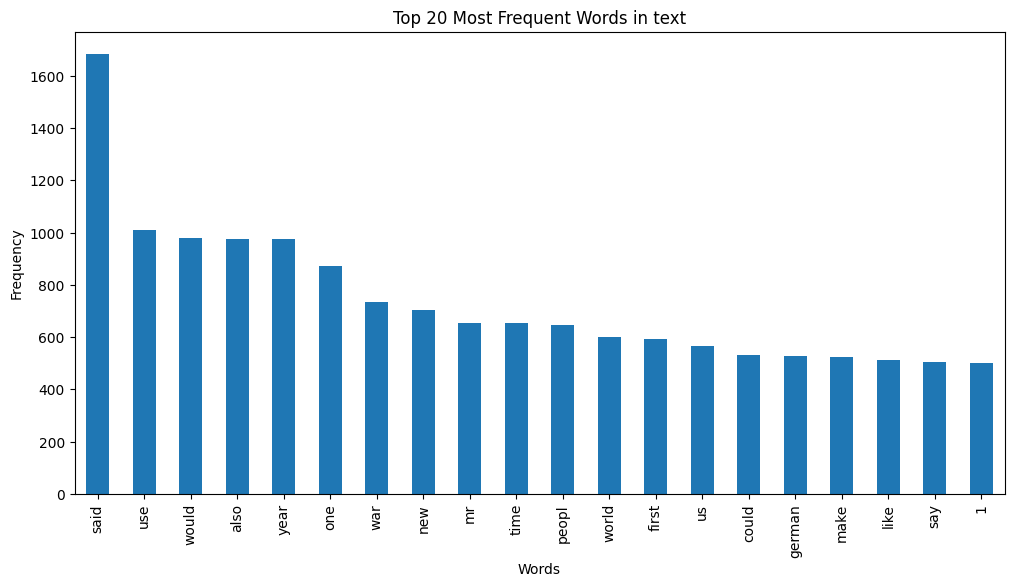

In [6]:
document_column = "text"

# create a series containing all the words in the document
all_words = pd.Series(' '.join(df[document_column]).lower().split())

# count the frequency of each word and sort by frequency
word_counts = all_words.value_counts().sort_values(ascending=False)

# specify the number of most frequent words to visualize
num_words_to_visualize = 20

# create a bar plot of the top N most frequent words
plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in {document_column}')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

### encode the text

In [7]:
model = SentenceTransformer('all-mpnet-base-v2')
encoded_texts = model.encode(df['text'])
encoded_texts = pd.DataFrame(encoded_texts, index=df.index)

pickle.dump(model , open('./pkl/model.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)

# encoded_summarize_texts = model.encode(df['summarize_text'])
# pickle.dump(model , open('../pkl/summarize_model.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)


### train and find accuracy

In [8]:
test_size_num = 0.2
max_iter_num = 2000

X_train, X_test, y_train, y_test = train_test_split(encoded_texts, df['label'], test_size=test_size_num, random_state=42)

clf = LogisticRegression(max_iter=max_iter_num)
clf.fit(X_train, y_train)

y_pred = pd.Series(clf.predict(X_test), index = X_test.index)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

pickle.dump(clf , open('./pkl/clf.pkl' , 'wb'))

Accuracy: 0.955
Classification Report:
               precision    recall  f1-score   support

     business       0.89      0.85      0.87        20
entertainment       1.00      1.00      1.00        13
         food       1.00      0.96      0.98        27
     graphics       0.95      1.00      0.98        21
   historical       1.00      1.00      1.00        15
      medical       0.88      0.95      0.91        22
     politics       0.96      1.00      0.98        25
        space       0.92      0.85      0.88        13
        sport       1.00      0.96      0.98        23
  technologie       0.95      0.95      0.95        21

     accuracy                           0.95       200
    macro avg       0.96      0.95      0.95       200
 weighted avg       0.96      0.95      0.95       200



In [9]:
eval_df = pd.DataFrame({"y_pred":y_pred, "y_test":y_test})
eval_df[eval_df['y_pred'] == 'medical']

,y_pred,y_test
521,medical,medical
513,medical,medical
549,medical,medical
527,medical,medical
584,medical,medical
570,medical,medical
261,medical,food
578,medical,medical
30,medical,business
542,medical,medical


In [10]:
print(df.loc[261]['text'])

everi day doctor write prescript medic treat variou ailment patient prescript though come patient alreadi sick effort stop diseas start research push polici program would let doctor prescrib healthi food insur cover help patient shift diet type program work subsid fruit veget healthi food medicar medicaid could prevent million case well death cardiovascular diseas accord new model would prevent hundr thousand diabet case well save billion dollar healthcar cost power food medicin increasingli clear say studi author dariush mozaffarian dean friedman school nutrit scienc polici tuft univers idea treat food key element healthcar catch across healthcar industri say rita nguyen assist health offic san francisco depart public health peopl recogn common sens say spend much healthcar outcom abysm invest food medicin mean individu food use treat individu condit diseas healthi diet help manag diseas nguyen lead risk factor cardiovascular diseas exampl poor diet food insecur treat someon give food

In [11]:
y_test

521       medical
737         space
740         space
660      politics
411    historical
          ...    
408    historical
332      graphics
208          food
613      politics
78       business
Name: label, Length: 200, dtype: object

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
labels=['medical', 'space', 'politics', 'historical', 'sport',
       'entertainment', 'business', 'technologie', 'food', 'graphics']

report = confusion_matrix(y_test, y_pred, labels=labels)
report = pd.DataFrame(report, index = labels, columns=labels)
report

,medical,space,politics,historical,sport,entertainment,business,technologie,food,graphics
medical,21,1,0,0,0,0,0,0,0,0
space,0,11,0,0,0,0,2,0,0,0
politics,0,0,25,0,0,0,0,0,0,0
historical,0,0,0,15,0,0,0,0,0,0
sport,1,0,0,0,22,0,0,0,0,0
entertainment,0,0,0,0,0,13,0,0,0,0
business,1,0,1,0,0,0,17,1,0,0
technologie,0,0,0,0,0,0,0,20,0,1
food,1,0,0,0,0,0,0,0,26,0
graphics,0,0,0,0,0,0,0,0,0,21


### mlflow

In [14]:
mlflow.set_experiment('Logistic Regression')

dataset: PandasDataset = mlflow.data.from_pandas(df)

with mlflow.start_run():
    mlflow.log_input(dataset)
    mlflow.log_param("data_folder_path", data_folder_path)
    mlflow.log_param("test_size_num", test_size_num)
    mlflow.log_param("max_iter_num", max_iter_num)
    mlflow.log_param("word_count_num", word_count_num)
    mlflow.log_artifact('./pkl/model.pkl')
    mlflow.log_artifact('./pkl/clf.pkl')
    mlflow.log_metric("accuracy", accuracy)


DataFrame.applymap has been deprecated. Use DataFrame.map instead.


### test new text with the model

In [15]:
new_text = ["the vast expanse beyond Earth's atmosphere, has long captivated human imagination and scientific curiosity. It's a realm of infinite wonder and mystery, where celestial bodies and phenomena defy our earthly understanding. One of the most awe-inspiring aspects of space is the sheer scale. It extends beyond our comprehension, with galaxies separated by immense distances. The Milky Way, our home galaxy, contains billions of stars, and there are billions of galaxies in the observable universe. Space is a place of extremes. In the vacuum of space, temperatures can range from scorching heat to frigid cold. On distant planets and moons, we find landscapes that challenge our perception of what is possible, from the towering volcanoes of Io to the icy geysers of Enceladus. "\
"Exploration of space has been a defining endeavor of human history. From the first satellite, Sputnik, to the monumental Apollo Moon missions, we have reached out to touch the stars. Today, robotic probes explore distant planets and spacecraft venture into the Kuiper Belt and beyond. "\
"Space is not only a realm of science but also a source of inspiration. It fuels our dreams of exploration and discovery, and it reminds us of our place in the grand tapestry of the cosmos. As we continue to gaze skyward, the mysteries of space continue to beckon, promising new insights and adventures that will shape the future of humanity",
"Football, known as soccer in some parts of the world, stands as more than just a sport; it's a universal language that transcends cultural boundaries, igniting passion and camaraderie in the hearts of millions. From the bustling streets of Rio de Janeiro to the quiet fields of rural Africa, football captivates diverse communities, creating a shared experience that goes beyond the ninety minutes on the pitch."
]
encoded_new_text = model.encode(new_text)

predicted_labels = clf.predict(encoded_new_text)

predicted_labels

array(['space', 'sport'], dtype=object)

### create generated text with gpt3

In [16]:
generatedText = utils.generate_text_with_openai('sport')

encoded_new_text = model.encode(generatedText)

predicted_labels = clf.predict([encoded_new_text])
predicted_labels

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

### terminal commands

In [ ]:
#docker image build --tag text_labeling .
#docker images
#docker container run --publish 80:80 --name text_labeling-container text_labeling

#uvicorn main:app --reload
#mlflow ui
#pip freeze
#streamlit run app.py

In [ ]:
# from gensim.summarization import summarize

# # Your long text
# long_text = df['text'][0]

# # Generate a summary
# summary = summarize(text=long_text)
# print(long_text)
# print(summary)

### clustering - kmeans

In [23]:
documents = df['text']
y = df['label']

vectorizer = TfidfVectorizer(max_df=0.85, min_df=0.05, stop_words='english')
X = vectorizer.fit_transform(documents)

k_means = KMeans(n_clusters=10, n_init = 'auto')
cluster_labels  = k_means.fit_predict(X)

adjusted_rand_score_value  = adjusted_rand_score(cluster_labels,y)
adjusted_rand_score_value


0.538139812564463

In [24]:
pickle.dump(vectorizer , open('./pkl/vectorizer.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(k_means , open('./pkl/kmeans.pkl' , 'wb'), pickle.HIGHEST_PROTOCOL)

In [25]:
labels = ['business', 'entertainment', 'food', 'graphics', 'historical', 'medical', 'politics', 'space', 'sport', 'technologie']
labels_to_cluster = {}
i = 0
for x in labels:
 
  unique_values, counts = np.unique(cluster_labels[(i*100):((i+1)*100)], return_counts=True)
  max_index = np.argmax(counts)
  
  max_value = unique_values[max_index]
  labels_to_cluster[x] = max_value
  i += 1


In [26]:
def reverse_dict(original_dict):
    reversed_dict = {}
    for key, value in original_dict.items():
        if value in reversed_dict:
            reversed_dict[value].append(key)
        else:
            reversed_dict[value] = [key]
    return reversed_dict

def find_missing_number(input_list):
    all_numbers = set(range(10))  
    present_numbers = set(input_list)

    missing_number = all_numbers - present_numbers

    if missing_number:
        return missing_number.pop()
    else:
        return None 

cluster_to_label = reverse_dict(labels_to_cluster)
missing_number = find_missing_number([*cluster_to_label])

In [27]:
missing_number

7

In [32]:
df['cluster_labels'] = cluster_labels
df[df['cluster_labels'] == missing_number].groupby(df['label'])['label'].value_counts().idxmax()[0]



'graphics'

In [ ]:
pickle.dump(labels_to_cluster, open('./pkl/labels_to_cluster.pkl' , 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
generatedText = utils.generate_text_with_openai('sport')
X_new = vectorizer.transform([generatedText])
cluster_labels_new = k_means.predict(X_new)
cluster_labels_new[0]
#cluster_to_label.get(cluster_labels_new[0])

3

In [ ]:
new_text = ["the vast expanse beyond Earth's atmosphere, has long captivated human imagination and scientific curiosity. It's a realm of infinite wonder and mystery, where celestial bodies and phenomena defy our earthly understanding. One of the most awe-inspiring aspects of space is the sheer scale. It extends beyond our comprehension, with galaxies separated by immense distances. The Milky Way, our home galaxy, contains billions of stars, and there are billions of galaxies in the observable universe. Space is a place of extremes. In the vacuum of space, temperatures can range from scorching heat to frigid cold. On distant planets and moons, we find landscapes that challenge our perception of what is possible, from the towering volcanoes of Io to the icy geysers of Enceladus. "\
"Exploration of space has been a defining endeavor of human history. From the first satellite, Sputnik, to the monumental Apollo Moon missions, we have reached out to touch the stars. Today, robotic probes explore distant planets and spacecraft venture into the Kuiper Belt and beyond. "\
"Space is not only a realm of science but also a source of inspiration. It fuels our dreams of exploration and discovery, and it reminds us of our place in the grand tapestry of the cosmos. As we continue to gaze skyward, the mysteries of space continue to beckon, promising new insights and adventures that will shape the future of humanity",
"Football, known as soccer in some parts of the world, stands as more than just a sport; it's a universal language that transcends cultural boundaries, igniting passion and camaraderie in the hearts of millions. From the bustling streets of Rio de Janeiro to the quiet fields of rural Africa, football captivates diverse communities, creating a shared experience that goes beyond the ninety minutes on the pitch."
]

X_new = vectorizer.transform(new_text)
cluster_labels_new = k_means.predict(X_new)
cluster_labels_new


array([3, 3])

In [ ]:
mlflow.set_experiment('KMeans Clustering')

dataset: PandasDataset = mlflow.data.from_pandas(df)

with mlflow.start_run():
    mlflow.log_input(dataset)
    mlflow.log_param("data_folder_path", data_folder_path)
    mlflow.log_artifact('./pkl/kmeans.pkl')
    mlflow.log_artifact('./pkl/vectorizer.pkl')
    mlflow.log_metric("adjusted_rand_score", adjusted_rand_score_value)
    mlflow.log_artifact("./plot/clustering.png", artifact_path="plots")

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=10)
y_pred = hierarchical.fit_predict(X.toarray())
adjusted_rand_score_value = adjusted_rand_score(y_pred,y )

mlflow.set_experiment('Agglomerative Clustering')

dataset: PandasDataset = mlflow.data.from_pandas(df)

with mlflow.start_run():
    mlflow.log_input(dataset)
    mlflow.log_param("data_folder_path", data_folder_path)
    #mlflow.log_artifact('./pkl/kmeans.pkl')
    mlflow.log_artifact('./pkl/vectorizer.pkl')
    mlflow.log_metric("adjusted_rand_score", adjusted_rand_score_value)
    mlflow.log_artifact("./plot/clustering.png", artifact_path="plots")

adjusted_rand_score_value

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


0.4101161117134756

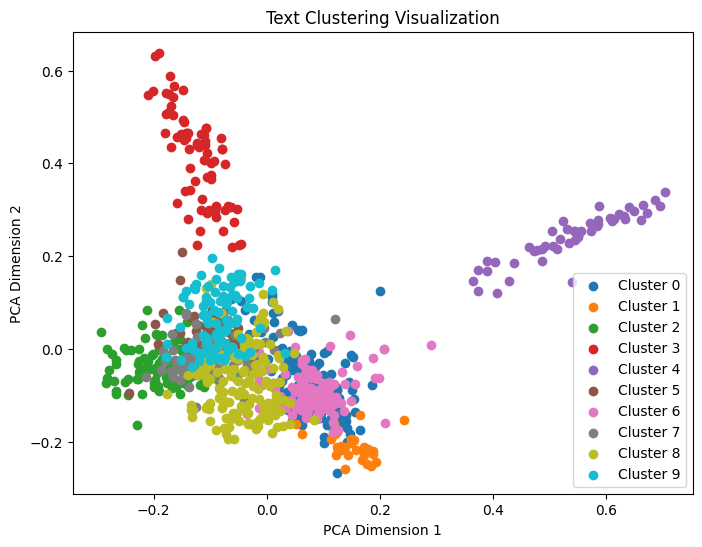

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

cluster_labels = k_means.labels_

# Reduce dimensionality for visualization (using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot to visualize clusters
plt.figure(figsize=(8, 6))

for i in range(10):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('Text Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()

plt.savefig("./plot/clustering.png")
plt.show()


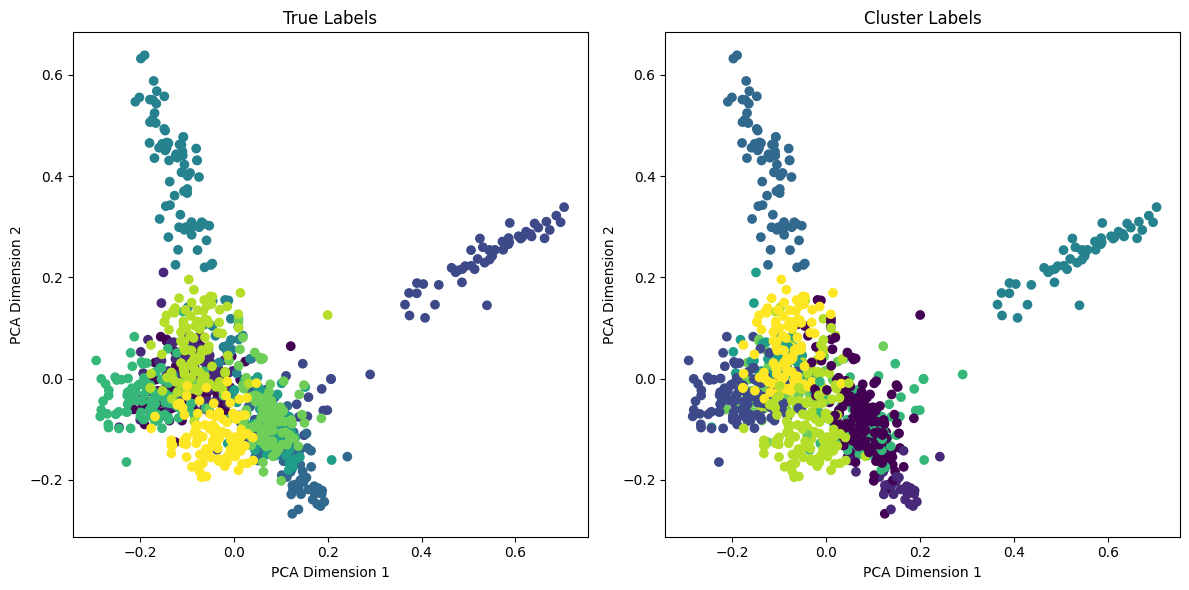

In [ ]:
# Create scatter plot for true labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['label_as_number'], cmap='viridis')
plt.title('True Labels')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Cluster Labels')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.tight_layout()
plt.show()

